In [1]:
import argparse
from argparse import Namespace 
import torch
from torchmdnet import calculators
from torchmdnet.calculators import External
from torchmdnet.utils import LoadFromFile, LoadFromCheckpoint, save_argparse, number
from torchmdnet import datasets, priors, models
from torchmdnet.data import DataModule
from torchmdnet.models import output_modules
from torchmdnet.models.utils import rbf_class_mapping, act_class_mapping
from torchmdnet.models.model import load_model, create_model

from moleculekit.molecule import Molecule
from torchmd.forcefields.ff_yaml import YamlForcefield
from torchmd.forcefields.forcefield import ForceField
from torchmd.forces import Forces
from torchmd.integrator import Integrator, maxwell_boltzmann
from torchmd.parameters import Parameters
from torchmd.systems import System
from torchmd.wrapper import Wrapper

from torchmdexp.nn.train import external_forces, setup_forces, setup_system, forward, loss_fn, train_model

from tqdm import tqdm

## Load args file

In [2]:
def get_args():
    # fmt: off
    parser = argparse.ArgumentParser(description='Training')
    parser.add_argument('--load-model', action=LoadFromCheckpoint, help='Restart training using a model checkpoint')  # keep first
    parser.add_argument('--conf', '-c', type=open, action=LoadFromFile, help='Configuration yaml file')  # keep second
    parser.add_argument('--num-epochs', default=300, type=int, help='number of epochs')
    parser.add_argument('--batch-size', default=32, type=int, help='batch size')
    parser.add_argument('--inference-batch-size', default=None, type=int, help='Batchsize for validation and tests.')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--lr-patience', type=int, default=10, help='Patience for lr-schedule. Patience per eval-interval of validation')
    parser.add_argument('--lr-min', type=float, default=1e-6, help='Minimum learning rate before early stop')
    parser.add_argument('--lr-factor', type=float, default=0.8, help='Minimum learning rate before early stop')
    parser.add_argument('--lr-warmup-steps', type=int, default=0, help='How many steps to warm-up over. Defaults to 0 for no warm-up')
    parser.add_argument('--early-stopping-patience', type=int, default=30, help='Stop training after this many epochs without improvement')
    parser.add_argument('--weight-decay', type=float, default=0.0, help='Weight decay strength')
    parser.add_argument('--ema-alpha-y', type=float, default=1.0, help='The amount of influence of new losses on the exponential moving average of y')
    parser.add_argument('--ema-alpha-dy', type=float, default=1.0, help='The amount of influence of new losses on the exponential moving average of dy')
    parser.add_argument('--ngpus', type=int, default=-1, help='Number of GPUs, -1 use all available. Use CUDA_VISIBLE_DEVICES=1, to decide gpus')
    parser.add_argument('--num-nodes', type=int, default=1, help='Number of nodes')
    parser.add_argument('--precision', type=int, default=32, choices=[16, 32], help='Floating point precision')
    parser.add_argument('--log-dir', '-l', default='/trainings', help='log file')
    parser.add_argument('--splits', default=None, help='Npz with splits idx_train, idx_val, idx_test')
    parser.add_argument('--train-size', type=number, default=None, help='Percentage/number of samples in training set (None to use all remaining samples)')
    parser.add_argument('--val-size', type=number, default=0.05, help='Percentage/number of samples in validation set (None to use all remaining samples)')
    parser.add_argument('--test-size', type=number, default=0.1, help='Percentage/number of samples in test set (None to use all remaining samples)')
    parser.add_argument('--test-interval', type=int, default=10, help='Test interval, one test per n epochs (default: 10)')
    parser.add_argument('--save-interval', type=int, default=10, help='Save interval, one save per n epochs (default: 10)')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--distributed-backend', default='ddp', help='Distributed backend: dp, ddp, ddp2')
    parser.add_argument('--num-workers', type=int, default=4, help='Number of workers for data prefetch')
    parser.add_argument('--redirect', type=bool, default=False, help='Redirect stdout and stderr to log_dir/log')
    
    # model architecture
    parser.add_argument('--model', type=str, default='graph-network', choices=models.__all__, help='Which model to train')
    parser.add_argument('--output-model', type=str, default='Scalar', choices=output_modules.__all__, help='The type of output model')
    parser.add_argument('--prior-model', type=str, default=None, choices=priors.__all__, help='Which prior model to use')

    # architectural args
    parser.add_argument('--embedding-dimension', type=int, default=256, help='Embedding dimension')
    parser.add_argument('--num-layers', type=int, default=6, help='Number of interaction layers in the model')
    parser.add_argument('--num-rbf', type=int, default=64, help='Number of radial basis functions in model')
    parser.add_argument('--num-filters', type=int, default=128, help='Number of filters in model')    
    parser.add_argument('--activation', type=str, default='silu', choices=list(act_class_mapping.keys()), help='Activation function')
    parser.add_argument('--rbf-type', type=str, default='expnorm', choices=list(rbf_class_mapping.keys()), help='Type of distance expansion')
    parser.add_argument('--trainable-rbf', type=bool, default=False, help='If distance expansion functions should be trainable')
    parser.add_argument('--neighbor-embedding', type=bool, default=False, help='If a neighbor embedding should be applied before interactions')
    
    # dataset specific
    parser.add_argument('--data_dir', default=None, help='Input directory')
    parser.add_argument('--dataset', default=None, type=str, choices=datasets.__all__, help='Name of the torch_geometric dataset')
    parser.add_argument('--dataset-root', default='~/data', type=str, help='Data storage directory (not used if dataset is "CG")')
    parser.add_argument('--dataset-arg', default=None, type=str, help='Additional dataset argument, e.g. target property for QM9 or molecule for MD17')
    parser.add_argument('--coord-files', default=None, type=str, help='Custom coordinate files glob')
    parser.add_argument('--embed-files', default=None, type=str, help='Custom embedding files glob')
    parser.add_argument('--energy-files', default=None, type=str, help='Custom energy files glob')
    parser.add_argument('--force-files', default=None, type=str, help='Custom force files glob')
    parser.add_argument('--energy-weight', default=1.0, type=float, help='Weighting factor for energies in the loss function')
    parser.add_argument('--force-weight', default=1.0, type=float, help='Weighting factor for forces in the loss function')

    # Transformer specific
    parser.add_argument('--distance-influence', type=str, default='both', choices=['keys', 'values', 'both', 'none'], help='Where distance information is included inside the attention')
    parser.add_argument('--attn-activation', default='silu', choices=list(act_class_mapping.keys()), help='Attention activation function')
    parser.add_argument('--num-heads', type=int, default=8, help='Number of attention heads')
    
    # Torchmdexp specific
    parser.add_argument('--device', default='cpu', help='Type of device, e.g. "cuda:1"')
    parser.add_argument('--forcefield', default="../data/ca_priors-dihedrals_general_2xweaker.yaml", help='Forcefield .yaml file')
    parser.add_argument('--forceterms', nargs='+', default="bonds", help='Forceterms to include, e.g. --forceterms Bonds LJ')
    parser.add_argument('--cutoff', default=None, type=float, help='LJ/Elec/Bond cutoff')
    parser.add_argument('--rfa', default=False, action='store_true', help='Enable reaction field approximation')
    parser.add_argument('--replicas', type=int, default=1, help='Number of different replicas to run')
    parser.add_argument('--step_update', type=int, default=5, help='Number of epochs to update the simulation steps')
    parser.add_argument('--switch_dist', default=None, type=float, help='Switching distance for LJ')
    parser.add_argument('--temperature',  default=300,type=float, help='Assign velocity from initial temperature in K')
    parser.add_argument('--force-precision', default='single', type=str, help='LJ/Elec/Bond cutoff')
    parser.add_argument('--verbose', default=None, help='Add verbose')
    parser.add_argument('--timestep', default=1, type=float, help='Timestep in fs')
    parser.add_argument('--langevin_gamma',  default=0.1,type=float, help='Langevin relaxation ps^-1')
    parser.add_argument('--langevin_temperature',  default=0,type=float, help='Temperature in K of the thermostat')
    parser.add_argument('--max_steps',type=int,default=2000,help='Total number of simulation steps')
    
    # other args
    parser.add_argument('--derivative', default=True, type=bool, help='If true, take the derivative of the prediction w.r.t coordinates')
    parser.add_argument('--cutoff-lower', type=float, default=0.0, help='Lower cutoff in model')
    parser.add_argument('--cutoff-upper', type=float, default=5.0, help='Upper cutoff in model')
    parser.add_argument('--atom-filter', type=int, default=-1, help='Only sum over atoms with Z > atom_filter')
    
    parser.add_argument('--max-z', type=int, default=100, help='Maximum atomic number that fits in the embedding matrix')
    parser.add_argument('--max-num-neighbors', type=int, default=32, help='Maximum number of neighbors to consider in the network')
    parser.add_argument('--standardize', type=bool, default=False, help='If true, multiply prediction by dataset std and add mean')
    parser.add_argument('--reduce-op', type=str, default='add', choices=['add', 'mean'], help='Reduce operation to apply to atomic predictions')

    args = parser.parse_args("")
    all_defaults = {}
    for key in vars(args):
        all_defaults[key] = parser.get_default(key)
    
    return all_defaults

In [3]:
args_dict = get_args()

In [4]:
# process_yaml.py file
import yaml

with open('../arguments/cln_gnn_arch2_brd.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    args_file = yaml.load(file, Loader=yaml.FullLoader)
for key, value in args_file.items():
    args_dict[key] = value
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
args = Struct(**args_dict)

In [5]:
def get_native_coords(mol, args):
    
    replicas = args.replicas
    device = args.device
    pos = torch.zeros(replicas, mol.numAtoms, 3)
    
    atom_pos = np.transpose(mol.coords, (2, 0, 1))
    if replicas > 1 and atom_pos.shape[0] != replicas:
        tom_pos = np.repeat(atom_pos[0][None, :], replicas, axis=0)

    pos[:] = torch.tensor(
            atom_pos, dtype=pos.dtype, device=pos.device
    )
    pos = pos.type(torch.float64)
    
    return pos

In [6]:
import numpy as np
mol = Molecule('../data/chignolin_cln025.pdb')
mol.filter('name CA')
args.replicas = 10
pos = get_native_coords(mol, args)

In [7]:
args.replicas

10

## Create native structure

In [8]:
import numpy as np
mol = Molecule('../data/chignolin_cln025.pdb')
mol.filter('name CA')

replicas = 1
device = 'cpu'
pos = torch.zeros(replicas, mol.numAtoms, 3)

atom_pos = np.transpose(mol.coords, (2, 0, 1))
if replicas > 1 and atom_pos.shape[0] != replicas:
    tom_pos = np.repeat(atom_pos[0][None, :], replicas, axis=0)

pos[:] = torch.tensor(
        atom_pos, dtype=pos.dtype, device=pos.device
)
pos = pos.type(torch.float64)



## Simulate Chingolin with pre-trained NN

Load the molecule

In [9]:
mol = Molecule('../data/chignolin_cln025.pdb')
mol.filter('name CA')
mol.read('../data/chignolin_cln025.psf')
mol.read('../data/chignolin_cln025.xtc')
args.replicas = 5
args.forceterms = ["repulsioncg"]

Load pretrained NN

In [10]:
netfile = '../data/epoch=47-val_loss=739.5398-test_loss=21.5975.ckpt'
model = load_model(netfile, device='cpu', derivative=True)
external = external_forces(model, mol, replicas = args.replicas, device = args.device)

In [20]:
model = load_model('../trainings/cln_gnn_r_02_09_arch2_trainset=50/epoch=13-loss=107.4896.ckpt', device='cpu', derivative=True)
model.to('cuda:0')

TorchMD_Net(
  (representation_model): TorchMD_GN(hidden_channels=128, num_filters=128, num_layers=4, num_rbf=18, rbf_type=expnorm, trainable_rbf=True, activation=tanh, neighbor_embedding=None, cutoff_lower=3.0, cutoff_upper=12.0, aggr=add)
  (output_model): Scalar(
    (output_network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [21]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.6356, -0.7801,  1.9025,  ...,  0.7004, -0.1737,  0.9497],
         [ 0.3925,  0.4847,  0.5985,  ...,  0.1284,  0.9382, -0.7931],
         [-0.8531, -0.9691, -0.6886,  ..., -1.1553, -1.6232,  1.5194],
         ...,
         [-0.2602,  0.3349,  0.1212,  ...,  1.4092, -0.3532,  0.1710],
         [-0.9505,  0.0763,  0.7244,  ...,  1.1066,  1.5381, -0.4207],
         [-0.3657, -0.1182, -0.1151,  ..., -0.1096, -0.3414,  1.2293]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0013,  0.0510,  0.1141,  0.1685,  0.2303,  0.2958,  0.3578,  0.4137,
          0.4777,  0.5246,  0.5832,  0.6556,  0.6986,  0.7573,  0.8138,  0.8776,
          0.9418,  1.0059], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([81.0252, 81.0277, 81.0214, 81.0247, 81.0130, 81.0165, 81.0178, 81.0166,
         81.0251, 81.0313, 81.0223, 81.0306, 81.0191, 81.0141, 81.0113, 81.0140,
         81.0236, 81.0251], device='cuda:0', requires_

Prepare the system

In [67]:
# Define forces and parameters
forces = setup_forces(mol, args.forcefield, args.forceterms, external = external, device=args.device, 
                        cutoff=args.cutoff, rfa=args.rfa, switch_dist=args.switch_dist
                        )   
# System
system = setup_system(mol, forces, replicas=args.replicas, T=args.temperature,
                        device=args.device
                         )

Run the simulation

In [57]:
steps = 2000
output_period = 10

# Simulation

# Integrator object
integrator = Integrator(system, forces, args.timestep, args.device, gamma=0.1, T=0)
native_coords = system.pos.clone().detach()
            
# Iterator and start computing forces
iterator = tqdm(range(1,int(steps/output_period)+1))
Epot = forces.compute(system.pos, system.box, system.forces)

for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)

 42%|█████████████████▋                        | 84/200 [05:20<07:22,  3.81s/it]


KeyboardInterrupt: 

In [139]:
loss, rmsd = loss_fn(pos, system.pos)
print('Final RMSD: ', rmsd)

Final RMSD:  1.1348059573142635


## Simulate Chingolin with pre-trained NN trained on lambda

In [35]:
mol = Molecule('../data/chignolin_cln025.pdb')
mol.filter('name CA')
mol.read('../data/chignolin_cln025.psf')
#mol.read('../data/chignolin_cln025.xtc')

In [36]:
lambda_net = '/workspace2/fast_folders_cgnet/multiprotein/single_prot_fix/lambda/train_geom_lambda_dih_4int_fix_rep1/epoch=85-val_loss=736.1273-test_loss=21.5217.ckpt'
model = load_model(lambda_net, device='cpu', derivative=True)
external = external_forces(model, mol, replicas = args.replicas, device = args.device)

In [37]:
# Define forces and parameters
forces = setup_forces(mol, args.forcefield, args.forceterms, external, device=args.device, 
                        cutoff=args.cutoff, rfa=args.rfa, switch_dist=args.switch_dist
                        )   
# System
system = setup_system(mol, forces, replicas=args.replicas, T=args.temperature,
                        device=args.device
                         )

In [38]:
steps = 750
output_period = 10
# Simulation

# Integrator object
integrator = Integrator(system, forces, args.timestep, args.device, gamma=0.1, T=0)
native_coords = system.pos.clone().detach()
            
# Iterator and start computing forces
iterator = tqdm(range(1,int(steps/output_period)+1))
Epot = forces.compute(system.pos, system.box, system.forces)

for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)

100%|███████████████████████████████████████████| 75/75 [00:13<00:00,  5.53it/s]


In [39]:
loss, rmsd = loss_fn(pos, system.pos)
print('Final RMSD: ', rmsd)

Final RMSD:  1.5965760210812099


## Simulate Chingolin with re-trained NN pretrained on lambda

In [40]:
mol = Molecule('../data/chignolin_cln025.pdb')
mol.filter('name CA')
mol.read('../data/chignolin_cln025.psf')
#mol.read('../data/chignolin_cln025.xtc')
#args.replicas = 10

In [41]:
trained_lambda_net = '/shared/carles/torchmd-exp/torchmdexp/nn/trainings/cln_prelambda_02_09/epoch=49-loss=1.6478.ckpt'
trained_lambda_net_model = load_model(trained_lambda_net, device='cpu', derivative=True)
external = external_forces(trained_lambda_net_model, mol, replicas = args.replicas, device = args.device)

In [42]:
# Define forces and parameters
forces = setup_forces(mol, args.forcefield, args.forceterms, external, device=args.device, 
                        cutoff=args.cutoff, rfa=args.rfa, switch_dist=args.switch_dist
                        )   
# System
system = setup_system(mol, forces, replicas=args.replicas, T=args.temperature,
                        device=args.device
                         )

In [43]:
steps = 750
output_period = 10

# Simulation

# Integrator object
integrator = Integrator(system, forces, args.timestep, args.device, gamma=0.1, T=0)
native_coords = system.pos.clone().detach()
            
# Iterator and start computing forces
iterator = tqdm(range(1,int(steps/output_period)+1))
Epot = forces.compute(system.pos, system.box, system.forces)

for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)

100%|███████████████████████████████████████████| 75/75 [00:11<00:00,  6.25it/s]


In [44]:
loss, rmsd = loss_fn(pos, system.pos)
print('Final RMSD: ', rmsd)

Final RMSD:  0.38887476885371375


## Simulate Chingolin with no external forces

In [95]:
mol = Molecule('../data/chignolin_cln025.pdb')
mol.filter('name CA')
mol.read('../data/chignolin_cln025.psf')
#mol.read('../data/chignolin_cln025.xtc')
#args.replicas = 10
args.forceterms = ["repulsioncg"]

In [52]:
# Define forces and parameters
forces = setup_forces(mol, args.forcefield, args.forceterms, external=None, device=args.device, 
                        cutoff=args.cutoff, rfa=args.rfa, switch_dist=args.switch_dist
                        )   
# System
system = setup_system(mol, forces, replicas=args.replicas, T=args.temperature,
                        device=args.device
                         )

In [53]:
steps = 750
output_period = 10

# Simulation

# Integrator object
integrator = Integrator(system, forces, args.timestep, args.device, gamma=0.1, T=0)
native_coords = system.pos.clone().detach()
            
# Iterator and start computing forces
iterator = tqdm(range(1,int(steps/output_period)+1))
Epot = forces.compute(system.pos, system.box, system.forces)

for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)

100%|███████████████████████████████████████████| 75/75 [00:01<00:00, 64.57it/s]


In [54]:
loss, rmsd = loss_fn(pos, system.pos)
print('Final RMSD: ', rmsd)

Final RMSD:  4.2818978649872665


## Simulate Chingolin with random NN

In [31]:
mol = Molecule('../data/chignolin_cln025.pdb')
mol.filter('name CA')
mol.read('../data/chignolin_cln025.psf')
#mol.read('../data/chignolin_cln025.xtc')
args.replicas = 1
args.forceterms = ["repulsioncg", "bonds", "dihedrals"]

In [27]:
model = create_model(args_dict)
external = external_forces(model, mol, replicas = args.replicas, device = args.device)

In [28]:
# Define forces and parameters
forces = setup_forces(mol, args.forcefield, args.forceterms, external=None, device=args.device, 
                        cutoff=args.cutoff, rfa=args.rfa, switch_dist=args.switch_dist
                        )   
# System
system = setup_system(mol, forces, replicas=args.replicas, T=args.temperature,
                        device=args.device
                         )

In [29]:
steps = 5000
output_period = 10

# Simulation

# Integrator object
integrator = Integrator(system, forces, args.timestep, args.device, gamma=0.1, T=0)
native_coords = system.pos.clone().detach()
            
# Iterator and start computing forces
iterator = tqdm(range(1,int(steps/output_period)+1))
Epot = forces.compute(system.pos, system.box, system.forces)

for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 61.21it/s]


In [30]:
loss, rmsd = loss_fn(pos, system.pos)
print('Final RMSD: ', rmsd)

Final RMSD:  4.347646792804146


## Sim time

In [68]:
times = [0.0,
244.92099738121033,
523.6174840927124,
804.427725315094,
1091.5886116027832,
1624.378838300705,
2242.731857061386,
2878.5688214302063,
3510.2826449871063,
4125.948407411575,
4996.646833658218,
6013.193626642227,
7035.383630514145,
8124.731684923172,
9176.599777936935,
10505.227858066559,
11976.055072069168,
13467.635905742645,
14951.779824495316]

In [69]:
dt = []
for idx, _ in enumerate(times):
    t1 = idx
    t2 = idx + 1
    if t2 == len(times):
        break
    dt.append(times[t2] - times[t1])

In [79]:
from statistics import mean
t_250 = mean(dt[:4])
t_500 = mean(dt[4:9])
t_750 = mean(dt[9:14])
t_1000 = mean(dt[14:19])

2021-09-02 00:00:55,433 - matplotlib.font_manager - INFO - Failed to extract font properties from /usr/share/fonts/google-noto-emoji/NotoColorEmoji.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
2021-09-02 00:00:55,589 - matplotlib.font_manager - INFO - generated new fontManager


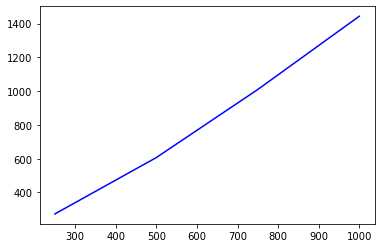

In [81]:
import matplotlib.pyplot as plt

sim_times = np.array([t_250, t_500, t_750, t_1000])
steps = np.array([250, 500, 750, 1000])

plt.plot(steps, sim_times, 'b', label = 'Time')